# Gaussian processes
**by Anton Gusarov, gusarov@kth.se**

The aim of this notebook is to illustrate the concepts of Gaussian processes. We will focus on three aspects of GPs: 
* the kernel
* the random sample paths 
* GP regression

We will use the [GPy package](https://sheffieldml.github.io/GPy/) by the Sheffield ML group.
The current draft of the online documentation of GPy is available from [this page](http://gpy.readthedocs.org/en/latest/).

In [1]:
%matplotlib inline
%config InLineBackend.fugure_format = 'retina'

import matplotlib
matplotlib.rcParams['figure.figsize'] = (5, 4)
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp
import GPy

## Part I
### 1. Defining a kernel

Let's start with **defining an exponentiated quadratic covariance function (kernel)** (also known as squared exponential or RBF or Gaussian) in one dimension:

In [2]:
dim = 1        # input dimension
var = 1.       # variance
theta = 0.2    # lengthscale
k = GPy.kern.RBF(dim, variance=var, lengthscale=theta)

A **summary of the kernel** can be obtained using the statement `print(k)`

In [3]:
print(k)

  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    0.2  |      +ve      |        


It is also possible to **plot the kernel as a function of one of its inputs** (whilst fixing the other) with `k.plot()`:

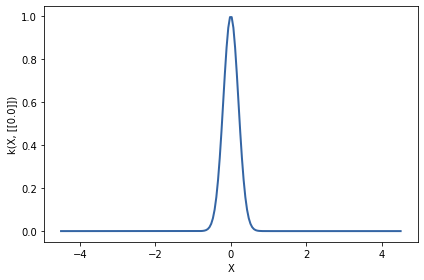

In [4]:
k.plot()
plt.show()

### 2. Setting the kernel parameters

The value of the covariance function parameters can be accessed and modified using `k['.*var']` where the string in bracket is a regular expression matching the parameter name as it appears in `print(k)`. Let's use this to get an insight into the effect of the parameters on the shape of the covariance function. 

Use it to set the lengthscale to different values, and then plot the resulting kernel using the `k.plot()` method.

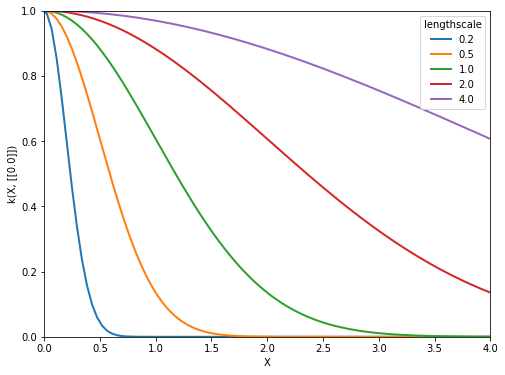

In [5]:
k = GPy.kern.RBF(dim) # by default the parameters are set to 1.
theta = np.asarray([0.2, 0.5, 1., 2., 4.])

fig, axes = plt.subplots(figsize=(8, 6))
for step, t in enumerate(theta):
    k.lengthscale = t  # accessing and setting the the kernel parameters
    k.plot(ax=axes, color=f'C{step}')
    plt.legend(theta, title='lengthscale')
    plt.axis([0,4, 0,1])

> The **lengthscale** (aka horizontal scale) $\ell$ describes how quickly the correlation between two points drops as the distance between them increases – **a high $\ell$ gives you a smooth function**, while lower $\ell$ results in a wiggly function.

Now change the code used above for plotting the covariances to see the influence of the variance parameter:

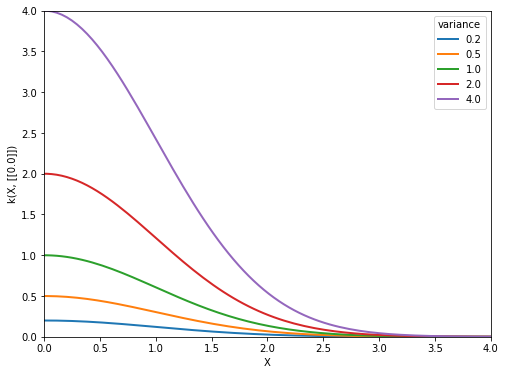

In [6]:
k = GPy.kern.RBF(dim) # by default the parameters are set to 1.
theta = np.asarray([0.2, 0.5, 1.0, 2.0, 4.0])

fig, axes = plt.subplots(figsize=(8, 6))
for step, v in enumerate(theta):
    k.variance = v  # accessing and setting the the kernel parameters
    k.plot(ax=axes, color=f'C{step}')
    plt.legend(theta, title='variance')
    plt.axis([0,4, 0,4])

In [7]:
# dir(k)  # to see all the methods behind the object

> The variance (vertical scale) $\sigma$ describes how much span the function has vertically.

### 3. Covariance functions in GPy

Many covariance functions are already implemented in GPy. Instead of RBF, try to construct and plot the following covariance kernels: 
> `Exponential`, 
`Matern32`, 
`Matern52`, 
`Brownian`, 
`Linear`, 
`Bias`,
`StdPeriodic`, 
`PeriodicExponential`, 
etc. 

Some of these covariance functions have more hyperparameters than just a variance and lengthscale. Furthermore, not all kernels are stationary (i.e., they can’t all be written as $k ( x, y) = f (x − y)$, see for example the Brownian
covariance function). For plotting, it may be interesting to change the value of the fixed input:

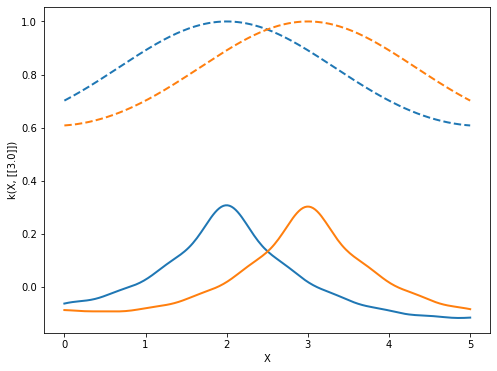

In [8]:
kb1 = GPy.kern.PeriodicExponential(input_dim=1, variance=1.0, lengthscale=1.0, period=6.28)
kb2 = GPy.kern.StdPeriodic(input_dim=1, variance=1.0, lengthscale=1.0, period=6.28)
inputs = np.array([2., 3.])

fig, ax = plt.subplots(figsize=(8,6))
for ix, x in enumerate(inputs):
    kb1.plot(x, plot_limits=[0,5], ax=ax, color=f"C{ix}")
    kb2.plot(x, plot_limits=[0,5], ax=ax, color=f"C{ix}", linestyle='--')

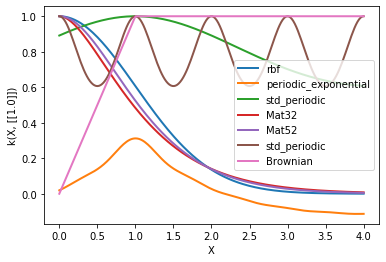

In [9]:
kernels = [
           GPy.kern.RBF(input_dim=1), 
           GPy.kern.PeriodicExponential(input_dim=1, variance=1.0, lengthscale=1.0, period=6.28),
           GPy.kern.StdPeriodic(input_dim=1, variance=1.0, lengthscale=1.0, period=6.28),
           GPy.kern.Matern32(input_dim=1),
           GPy.kern.Matern52(input_dim=1),
           GPy.kern.StdPeriodic(input_dim=1),
           GPy.kern.Brownian(input_dim=1)
           ]
            

fig, axes = plt.subplots(figsize=(6,4))
labels = list()
for step, k in enumerate(kernels):
    k.plot(ax=axes, plot_limits=[0, 4], color=f'C{step}')  # PARAMETERS OF .plot() METHOD
    labels.append(k.name)
    plt.legend(labels)  # must be iterable

### 4. Computing covariance function given the input data $\mathbf{X}$

Let $\mathbf{X}$ be a $n$ × $d$ numpy array. Given a kernel `k`, the covariance matrix associated to
$\mathbf{X}$ is obtained with `C = k.K(X,X)` . The positive semi-definiteness of $k$ ensures that `C`
is a positive semi-definite (psd) matrix regardless of the initial points $\mathbf{X}$. This can be
checked numerically by looking at the eigenvalues:
    

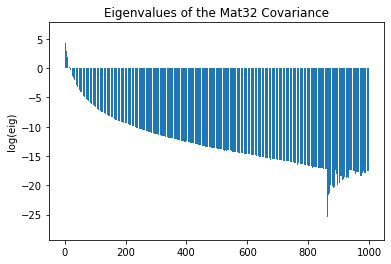

In [10]:
k = GPy.kern.Matern32(input_dim = 2)
X = np.sort(np.random.randn(1000, 2), axis=0) # 50x1 matrix of iid standard Gaussians  SORTED FOR BEATIFUL COV MATRIX

C = k.K(X,X)
eigvals = np.linalg.eigvals(C)  # Computes the eigenvalues of a matrix

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(np.arange(len(eigvals)), np.log(eigvals))
ax.set(ylabel='log(eig)',title=f'Eigenvalues of the {k.name} Covariance');  # Remember this trick (;)

In [11]:
C_sorted = np.sort(C, axis=0)
C_sorted2 = np.sort(C_sorted, axis=1)

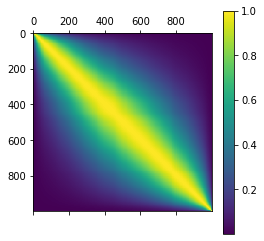

In [12]:
plt.matshow(C)
plt.colorbar();

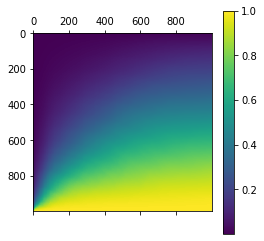

In [13]:
plt.matshow(C_sorted2)
plt.colorbar();

A matrix $\mathbf{C}$ is positive semi-definite if the matrix inner product, $\mathbf{x}^\top \mathbf{C}\mathbf{x}$ is greater than or equal to zero regardless of the values in $\mathbf{x}$. 

Given this **it should be easy to see that the sum of two positive semi-definite matrices is also positive semi-definite**. **In the context of Gaussian processes, this is the sum of two covariance functions. So, we can combine covariance functions by summation.**

$$
k(\mathbf{x}, \mathbf{x}^\prime) = k_1(\mathbf{x}, \mathbf{x}^\prime) + k_2(\mathbf{x}, \mathbf{x}^\prime)
$$

What about **the element-wise product** of two covariance functions? In other words if we define

$$
k(\mathbf{x}, \mathbf{x}^\prime) = k_1(\mathbf{x}, \mathbf{x}^\prime) \cdot k_2(\mathbf{x}, \mathbf{x}^\prime)
$$

### 5. Combining covariance functions in GPy

In GPy **you can easily combine covariance functions you have created using the sum and product operators, `+` and `*`**. So, for example, if we wish to combine an exponentiated quadratic covariance with a Matern 5/2 then we can write:

  sum.               |  value  |  constraints  |  priors
  rbf.variance       |    1.0  |      +ve      |        
  rbf.lengthscale    |    2.0  |      +ve      |        
  Mat52.variance     |    2.0  |      +ve      |        
  Mat52.lengthscale  |    4.0  |      +ve      |        


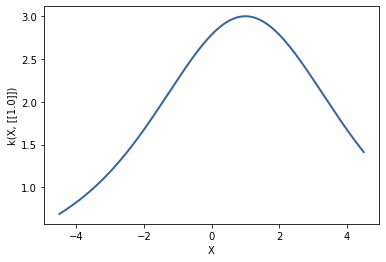

In [14]:
kern1 = GPy.kern.RBF(1, variance=1., lengthscale=2.)
kern2 = GPy.kern.Matern52(1, variance=2., lengthscale=4.)
kern = kern1 + kern2
# kern = kern1 * kern2
print(kern)
fig, axes = plt.subplots(figsize=(6,4))
kern.plot(ax=axes);

## Part II: sampling from a Gaussian process

The Gaussian process provides a prior over an infinite dimensional function. **It is defined by a covariance *function* and a mean *function*.** When we compute the covariance matrix using `kern.K(X, X)` we are computing a covariance *matrix* between the values of the function that correspond to the input locations in the matrix `X`.

If we want to have a look at the type of functions that arise from a particular Gaussian process we can never generate all values of the function, because there are infinite values.

However, **we can generate samples from a Gaussian distribution based on a covariance matrix associated with a particular matrix of input locations X**. If these locations are chosen appropriately then they give us a good idea of the underlying function. For example, for a one dimensional function, if we choose `X` to be uniformly spaced across part of the real line, and the spacing is small enough, we'll get an idea of the underlying function. We will now use this trick to draw sample paths from a Gaussian process:

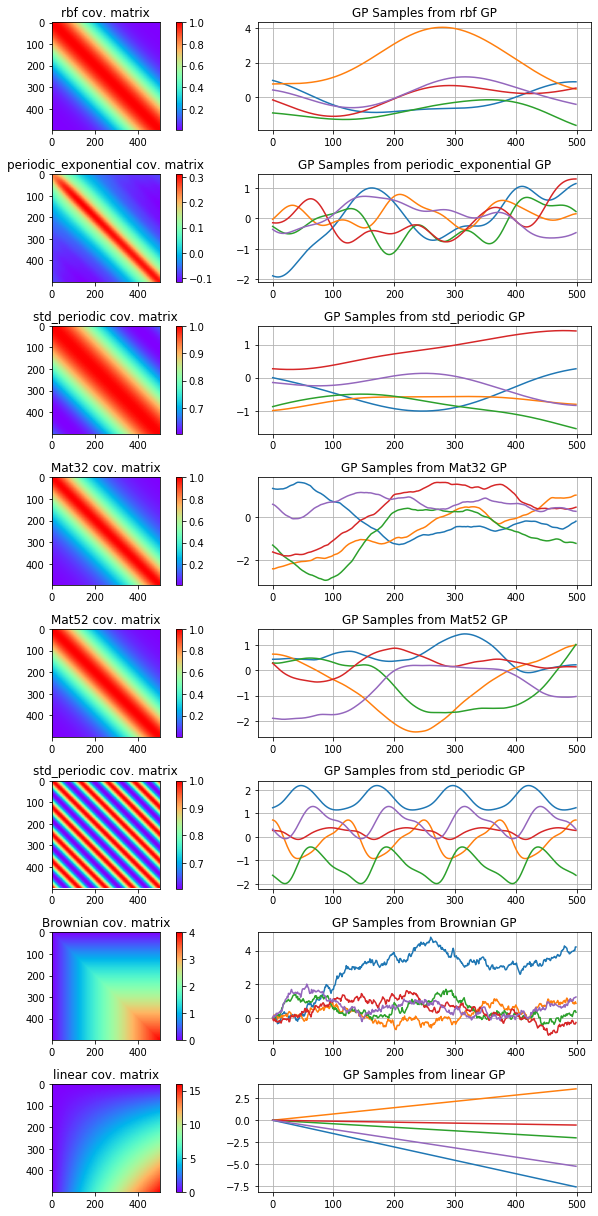

In [15]:
kernels = [
           GPy.kern.RBF(input_dim=1), 
           GPy.kern.PeriodicExponential(input_dim=1, variance=1.0, lengthscale=1.0, period=6.28),
           GPy.kern.StdPeriodic(input_dim=1, variance=1.0, lengthscale=1.0, period=6.28),
           GPy.kern.Matern32(input_dim=1),
           GPy.kern.Matern52(input_dim=1),
           GPy.kern.StdPeriodic(input_dim=1),
           GPy.kern.Brownian(input_dim=1),
           GPy.kern.Linear(input_dim=1)
           ]

X = np.linspace(0., 4., 500) # define X to be 500 points evenly spaced over [0,1]
X = X[:, None]               # reshape X to make it n*d - GPy uses 'design matrices'
mu = np.zeros(len(X))        # vector of the means - we could use a mean function here, but here it is just zero.
n_samples = 5                # Generate 'n_samples' separate samples paths from a Gaussian with mean mu and covariance C

plt.figure(figsize=(10,17))
for step, k in enumerate(kernels, 1):
    C = k.K(X,X)  # compute the covariance matrix associated with inputs X
    plt.subplot(len(kernels), 2, 2*step-1)
    plt.imshow(C, cmap='rainbow')
    plt.colorbar()
    plt.gca().set_title(f'{k.name} cov. matrix')
    plt.subplot(len(kernels), 2, 2*step)
    
    for i in range(n_samples):
        sample = np.random.multivariate_normal(mu, C)  # take a single sample from GP
        plt.plot(sample)
        plt.grid(True)
    plt.gca().set_title(f'GP Samples from {k.name} GP')
    
plt.tight_layout()

## Part III: GP regression

We will now combine the Gaussian process prior with some data to form a GP regression model with GPy. 

Generate data from the function $f ( x ) = − \cos(\pi x ) + \sin(4\pi x )$ over $[0,\ 1]$, then add some AWGN to give $y(x) = f(x) + \epsilon$, where $\epsilon \sim \mathcal{N}(0,\ 0.01)$. 

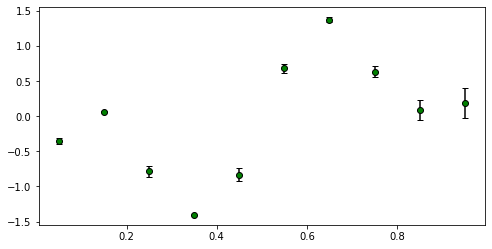

In [16]:
X = np.linspace(0.05, 0.95, 10)[:,None]
yerr = np.random.normal(loc=0.0, scale=0.1, size=(10,1))
Y = -np.cos(np.pi*X) + np.sin(4*np.pi*X) + yerr
fig, ax = plt.subplots(figsize=(8, 4))

ax.errorbar(X, Y, yerr=yerr.ravel(), fmt='ok', mec='k', mfc='g', capsize=3, label='Data');

A GP regression model based on an exponentiated quadratic covariance function can be defined by **first defining a covariance function**:

In [17]:
kernel = GPy.kern.RBF(input_dim=X.shape[1]) # default parameters

Then combine it with the data to form a Gaussian process model:

In [18]:
GP_regr_model = GPy.models.GPRegression(X, Y, kernel)
print(GP_regr_model)


Name : GP regression
Objective : 13.397880899698265
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


We can see the posterior mean prediction and visualize the marginal posterior variances using `m.plot()`.

**Note:** The `plot` command shows the mean of the GP model as well as the 95% confidence region.

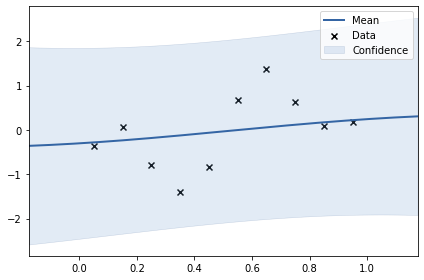

In [19]:
GP_regr_model.plot();  # plot non-optimized model

The actual predictions of the model for a set of points `Xnew` can be computed using 
```python
Ynew, Yvar = m.predict(Xnew)
```

Note that `Xnew` is an $m \times p$ array, where $m$ is the number of points that we want to predict and $p$ is the dimensionality of the parameter space.

We can also extract the predictive quantiles around the prediction at `Xnew`.
```python
Ylo95, Yhi95 = m.predict_quantiles(Xnew)
```

In [20]:
Xnew = np.linspace(0.0, 1.5, 4)[:,None]
(Ymean, Yvar)  = GP_regr_model.predict(Xnew)
(Ylo95,Yhi95)  = GP_regr_model.predict_quantiles(Xnew)  # quantiles=(2.5, 97.5) are default

print(r"  X   mean Y   var Y   lo95%   hi95%")
for (Xi, Ymeani, Yvari, Yloi, Yhii) in zip(Xnew, Ymean, Yvar, Ylo95, Yhi95):
    print(f"{Xi[0]:5.2f}  {Ymeani[0]:5.2f}   {Yvari[0]:5.2f}   {Yloi[0]:5.2f}   {Yhii[0]:5.2f}")

  X   mean Y   var Y   lo95%   hi95%
 0.00  -0.30    1.20   -2.45    1.85
 0.50  -0.03    1.10   -2.09    2.02
 1.00   0.24    1.20   -1.91    2.39
 1.50   0.36    1.48   -2.03    2.74


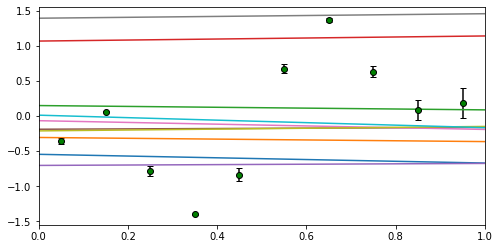

In [21]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.errorbar(X, Y, yerr=yerr.ravel(), fmt='ok', mec='k', mfc='g', capsize=3, label='Data')
n_samples = 10
C = kernel.K(X,X)
mu = np.zeros(len(X))
for i in range(n_samples):
    sample = np.random.multivariate_normal(mu, C)  # take a single sample from GP
    ax.plot(sample)
    ax.set_xlim((0,1))
    ax.set_ylim((-1.55, 1.55))

### Kernel parameter estimation

The kernel **parameter values can be estimated by maximizing the *likelihood* of the observations.** Since we don’t want one of the variances to become negative during the optimization, **we can constrain all parameters to be positive** before running the optimisation:

In [22]:
GP_regr_model.constrain_positive()

reconstraining parameters GP_regression


The warnings are because the parameters are already constrained by default, the software is warning us that they are being reconstrained.

Now we can optimize the model using the `m.optimize()` method:


Name : GP regression
Objective : 6.49859623208679
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |      0.9109045035839367  |      +ve      |        
  rbf.lengthscale          |     0.13751433617464542  |      +ve      |        
  Gaussian_noise.variance  |  1.0767775439867207e-09  |      +ve      |        


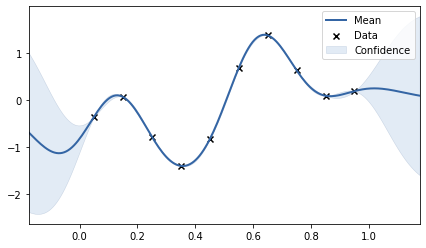

In [23]:
GP_regr_model.optimize()

fig2, axes2 = plt.subplots(figsize=(7,4))
GP_regr_model.plot(ax=axes2)
print(GP_regr_model)